In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter

In [21]:
# ==================== Define functions ====================

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result


# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' 
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')


# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')





# ==================== Create Train-Validate-Test dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)


[Type Model] You have chosen Full_Cov
[Checking Calibration] Matched Coordinators
[Sampling Grid] Training Grids: 166 ----- Validating Grids: 30 ----- Testing Grids: 30
===== Sampling Model =====
[Saving] Save Grid Index
[Saving] Done Saving Grid Index
[Preprocessing] Total Training containing NA: 0 / 488914 ----- 0.0%
[Preprocessing] Total Validating containing NA: 0 / 89152 ----- 0.0%
[Preprocessing] Total Testing containing NA: 0 / 123240 ----- 0.0%
[Preprocessing] Total EndemicDF containing NA: 0 / 896827 ----- 0.0%


In [22]:
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)
  
    # Plot overall.
    with sns.color_palette('Blues', 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total Quantile Loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile Loss')
        plt.ylabel('')
        ax.legend_.remove()
        filename_plot = 'Total_Quantile_Loss.png'
        plt.rc('font',size = 15)
        plt.rc('axes',labelsize = 15)
        plt.tight_layout()
        ax.figure.savefig(Savepath + filename_plot)
  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)
  
    # Plot per quantile.
    with sns.color_palette('Blues'):
        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile Loss Per Quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile Loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))
        plt.rc('font',size = 15)
        plt.rc('axes',labelsize = 15)
        plt.tight_layout()
        filename_plot = 'Quantile_Loss_Per_Quantile.png'
        ax.figure.savefig(Savepath + filename_plot)        

In [4]:
METHODS = ['Random forests', 'Gradient boosting']
QUANTILES = [0.025, 0.975]
qdf = np.array([(method,q,y) 
               for method in METHODS
               for q in QUANTILES
               for y in Y_test]) 
qdf = pd.DataFrame(qdf)
qdf.columns = ['method', 'q', 'label']
qdf = qdf.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [63]:
qdf

,method,q,label
0,Random forests,0.025,0.163308
1,Random forests,0.025,0.164386
2,Random forests,0.025,0.165014
3,Random forests,0.025,0.163172
4,Random forests,0.025,0.163207
...,...,...,...
356603,Gradient boosting,0.975,0.414600
356604,Gradient boosting,0.975,0.414617
356605,Gradient boosting,0.975,0.414806
356606,Gradient boosting,0.975,0.415563


In [6]:
foi_gb = pd.read_csv('Generate/Python_Export/GB/Test_FOI_GB_quantile_Full_Cov_400.csv',sep = '\t')
foi_gb

,Unnamed: 0,x,y,Actual,Predict,Lower,Upper
0,0,13717.407892,5959.817018,0.163308,0.126633,0.064931,0.163522
1,1,13722.407892,5959.817018,0.164386,0.128194,0.064948,0.164742
2,2,13727.407892,5959.817018,0.165014,0.127657,0.064948,0.165265
3,3,13747.407892,5959.817018,0.163172,0.129828,0.064901,0.163277
4,4,13757.407892,5959.817018,0.163207,0.129194,0.064948,0.163277
...,...,...,...,...,...,...,...
89147,692818,15422.407892,-625.182982,0.414600,0.396009,0.063363,0.417270
89148,692819,15427.407892,-625.182982,0.414617,0.395316,0.063363,0.416820
89149,692820,15437.407892,-625.182982,0.414806,0.366562,0.066241,0.397371
89150,692821,15442.407892,-625.182982,0.415563,0.313691,0.066241,0.388860


In [7]:
foi_rf = pd.read_csv('Generate/Python_Export/RF/Test_FOI_RF_quantile_Full_Cov_400.csv',sep = '\t')
foi_rf

,Unnamed: 0,x,y,Actual,Predict,Lower,Upper
0,0,13717.407892,5959.817018,0.163308,0.153669,0.090936,0.177019
1,1,13722.407892,5959.817018,0.164386,0.154116,0.091125,0.176836
2,2,13727.407892,5959.817018,0.165014,0.154412,0.089947,0.178227
3,3,13747.407892,5959.817018,0.163172,0.154754,0.093749,0.177795
4,4,13757.407892,5959.817018,0.163207,0.154781,0.089947,0.181954
...,...,...,...,...,...,...,...
89147,692818,15422.407892,-625.182982,0.414600,0.414671,0.413088,0.415604
89148,692819,15427.407892,-625.182982,0.414617,0.414761,0.413665,0.415805
89149,692820,15437.407892,-625.182982,0.414806,0.392735,0.089125,0.416692
89150,692821,15442.407892,-625.182982,0.415563,0.348712,0.081457,0.418560


In [8]:
foi_rf_end = pd.read_csv('/Users/jiesun/Dropbox/PROJECT_JE/JE_Jie/0Modeling/Generate/Python_Export/RF/Endemic_FOI_RF_Quantile Regression_Full_Cov_400.csv',sep = '\t')
foi_rf_end
#min(foi_rf_end.Lower)

,Unnamed: 0,x,y,Predict,Lower,Upper
0,0,13717.407892,5959.817018,0.538342,0.522718,0.544139
1,1,13722.407892,5959.817018,0.538453,0.522765,0.544094
2,2,13727.407892,5959.817018,0.538526,0.522472,0.544439
3,3,13732.407892,5959.817018,0.538502,0.522718,0.544288
4,4,13737.407892,5959.817018,0.538162,0.521760,0.543964
...,...,...,...,...,...,...
896822,896822,15922.407892,-2195.182982,0.518919,0.507702,0.548904
896823,896823,15927.407892,-2195.182982,0.518725,0.507702,0.548904
896824,896824,15932.407892,-2195.182982,0.519974,0.507453,0.557042
896825,896825,15937.407892,-2195.182982,0.518687,0.504828,0.548904


In [9]:
qdf['pred'] = np.concatenate((np.asarray(foi_gb.Lower).reshape(-1,1),
               np.asarray(foi_gb.Upper).reshape(-1,1),
                              np.asarray(foi_rf.Lower).reshape(-1,1),
               np.asarray(foi_rf.Upper).reshape(-1,1)),axis = 0) 

In [10]:
qdf['quantile_loss'] = quantile_loss(qdf.q, qdf.label, qdf.pred)


In [11]:
qdf

,method,q,label,pred,quantile_loss
0,Random forests,0.025,0.163308,0.064931,0.002459
1,Random forests,0.025,0.164386,0.064948,0.002486
2,Random forests,0.025,0.165014,0.064948,0.002502
3,Random forests,0.025,0.163172,0.064901,0.002457
4,Random forests,0.025,0.163207,0.064948,0.002456
...,...,...,...,...,...
356603,Gradient boosting,0.975,0.414600,0.415604,0.000025
356604,Gradient boosting,0.975,0.414617,0.415805,0.000030
356605,Gradient boosting,0.975,0.414806,0.416692,0.000047
356606,Gradient boosting,0.975,0.415563,0.418560,0.000075


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

                   quantile_loss
method                          
Gradient boosting       0.001724
Random forests          0.003464
method  Gradient boosting  Random forests
q                                        
0.025            0.002278        0.002565
0.975            0.001171        0.004362


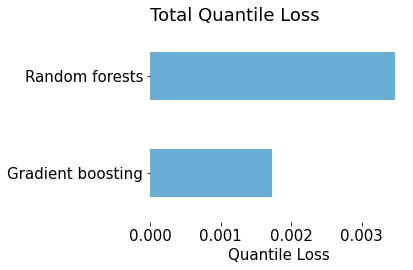

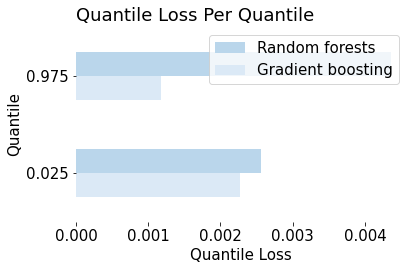

In [23]:
plot_loss_comparison(qdf)